<a href="https://colab.research.google.com/github/pizard/1-2-Chess/blob/master/8%2C9_Interpretable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/Shareddrives/LG_AI_Workshop_21W/8_9_Interpretable_Deep_Learning"

/content/drive/Shareddrives/LG_AI_Workshop_21W/8_9_Interpretable_Deep_Learning


# Part 1. Interpretable AI with Pytorch

### 0. Install torchcam
- torchcam이란 pytorch의 언어로 만들어진 Interpretable AI Library들을 구현해놓은 라이브러리입니다.
- 우리가 배웠던 CAM, GradCAM 뿐만아니라 LayerCAM, GradCAM++ 등 수 많은 방법들이 구현되어 있습니다.

In [ ]:
!pip install torchcam

     |████████████████████████████████| 4.3 MB 7.5 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### 1. Library Import

In [ ]:
import os

import numpy as np
import torch
import torchvision
import torch.nn as n
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable

import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline  

import random
from torchvision.models import resnet18
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

### 2. Hyper-Parameter
- Hyper-parameter를 지정해줍니다.

In [ ]:
batch_size = 128
learning_rate = 0.001
num_epoch = 4

### 3. Data Load
- torchvision에서 제공하는 library를 활용하여 CIFAR10 Dataset을 불러옵니다.


In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 128
train = dset.CIFAR10("./data", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2023, 0.1994, 0.2010))
                         ]),
                         target_transform=None, 
                         download=True)


test = dset.CIFAR10("./data", train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2023, 0.1994, 0.2010))
                        ]),
                        target_transform=None, 
                        download=True)


train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=False)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=False)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 4. Model, Loss Function, Optimizer Load

In [ ]:
from torchcam.methods import GradCAMpp, CAM

model = torchvision.models.resnet50(pretrained=False)
model = model.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. Train & Test

In [ ]:
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda().float()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image,volatile=True).cuda().float()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test Data Accuracy: [43.94]%
Test Data Accuracy: [47.2]%
Test Data Accuracy: [46.1]%
Test Data Accuracy: [40.48]%


### 6. Pre-trained Model Load
- 모델이 데이터를 학습하는데는 오랜 시간을 필요로 하기에 이번 수업시간에는 학습된 모델을 불러와 사용합니다.


In [ ]:
model = torchvision.models.resnet50(pretrained=True)


### 7. Image Load
- Activation Map을 확인해볼 이미지를 불러옵니다.

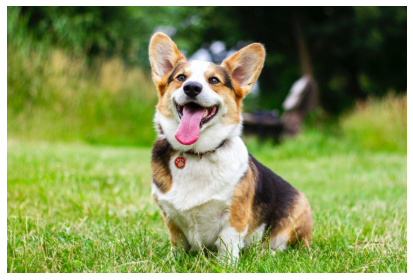

In [ ]:
# img = read_image("./cat_1.jpeg")
# img = read_image("./cat_2.jpeg")
# img = read_image("./cat_3.jpeg")
# img = read_image("./dog_1.jpeg")
img = read_image("./dog_2.jpeg")
# img = read_image("./dog_3.jpeg")

plt.imshow(to_pil_image(img)); 
plt.axis('off'); 
plt.tight_layout(); 
plt.show()

### 8. Image Preprocessing & GradCAM Load
- 주어진 이미지를 모델의 입력으로 사용하기 위해서는 기본 형태인 PIL가 아닌 모델에 적합한 입력의 형태로 바꿔줘야하기에 이를 전처리로 수행해줍니다.
- 실습에서 사용할 GradCAM 등의 Model들을 torchcam 라이브러리에서 불러옵니다.

In [ ]:
from torchcam.methods import CAM

input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

cam = CAM(model)

### 9. Get Activation Map I
- 입력 tensor를 모델에 넣어 gradient를 구하고 이를 활용하여 Activation map을 구해봅시다.

predicted label :  263


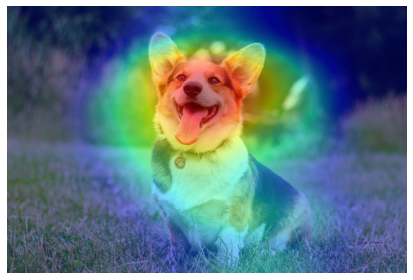

In [ ]:
out = model(input_tensor)
model.zero_grad()
predicted_label = out.squeeze(0).argmax().item()

activation_map = cam(predicted_label, out)

print("predicted label : ", predicted_label)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].detach().cpu().numpy(), mode='F'), alpha=0.5)
plt.imshow(result);
plt.axis('off');
plt.tight_layout(); 
plt.show()


### 실습 1
- 여러 고양이와 강아지 모델을 활용하여 모델이 어떤 부분을 참고하여 라벨을 예측했는지 확인해봅시다.

predicted label :  281


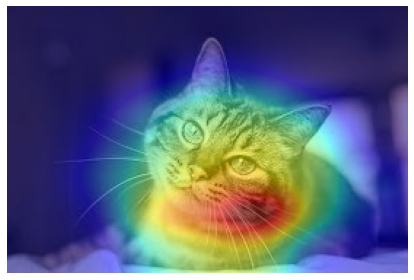

In [ ]:
# './cat_1.jpeg', './cat_2.jpeg', './cat_3.jpeg'
# './dog_1.jpeg', './dog_2.jpeg', './dog_3.jpeg'

img = read_image(???) # ← 이 부분에 이미지의 위치를 넣어주세요!

### 1. Image Load, 전처리
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

### 2. Model, CAM Load
model = torchvision.models.resnet50(pretrained=True)
cam = CAM(model)

### 3. Get Activation Map
out = model(input_tensor)
model.zero_grad()

predicted_label = out.squeeze(0).argmax().item()
activation_map = cam(predicted_label, out)

print("predicted label : ", predicted_label)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].detach().cpu().numpy(), mode='F'), alpha=0.5)
plt.imshow(result);
plt.axis('off');
plt.tight_layout(); 
plt.show()

### 실습 2
 - 다음 사진이 고양이로 예측되었을 때의 만들어지는 CAM을 그려보세요.
 - 학습된 모델에서 고양이의 라벨은 '281', 강아지의 라벨은 '371' 입니다.

predicted label :  281


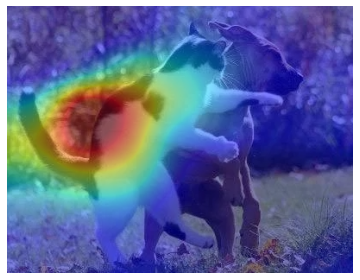

In [ ]:
### 1. Image Load, 전처리
img = read_image("./catdog.jpeg")

input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

### 2. Model, CAM Load
model = torchvision.models.resnet50(pretrained=True)
cam_extractor = CAM(model)

### 3. Get Activation Map
out = model(input_tensor)
model.zero_grad()

predicted_label = 281

activation_map = cam_extractor(predicted_label, out)

print("predicted label : ", predicted_label)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].detach().cpu().numpy(), mode='F'), alpha=0.5)
plt.imshow(result);
plt.axis('off');
plt.tight_layout(); 
plt.show()

# Part 2 심화과정
- 이전에서는 GradCAM을 구현하고 예측된 객체에 Acitivation Map이 생긱는 것을 확인했습니다.
- 이번장에서는 GradCAM과 CAM 사이의 차이를 확인해봅시다.

In [ ]:
from torchcam.methods import CAM, GradCAMpp

### 1. Image Load, 전처리
img = read_image("./dog_1.jpeg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

### 2. Model, CAM Load
model = torchvision.models.resnet50(pretrained=True)

cam_extractors = GradCAMpp(model, ['layer1', 'layer2', 'layer3', 'layer4'])
# cam_extractors = CAM(model, ['layer1', 'layer2', 'layer3', 'layer4'])

In [ ]:
out = model(input_tensor)
model.zero_grad()

predicted_label = out.squeeze(0).argmax().item()
cams = cam_extractors(predicted_label, out)

for cam in cams:
    print(cam.shape)

torch.Size([56, 56])
torch.Size([28, 28])
torch.Size([14, 14])
torch.Size([7, 7])


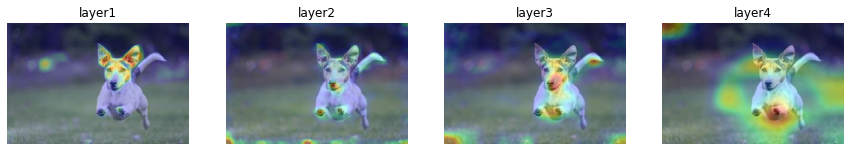

In [ ]:
_, axes = plt.subplots(1, len(cam_extractors.target_names), figsize=(15,15))

for idx, name, cam in zip(range(len(cam_extractors.target_names)), cam_extractors.target_names, cams):
    a = overlay_mask(to_pil_image(img), to_pil_image(cam.detach().cpu().numpy(), mode='F'), alpha=0.7)
    axes[idx].imshow(a);
    axes[idx].axis('off');
    axes[idx].set_title(name);

plt.show()

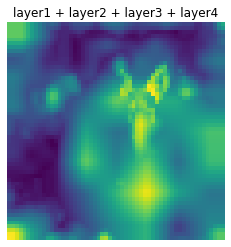

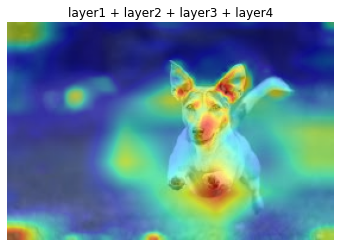

In [ ]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.numpy());
plt.axis('off');
plt.title(" + ".join(cam_extractors.target_names));
plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result);
plt.axis('off');
plt.title(" + ".join(cam_extractors.target_names));plt.show()

In [ ]:
from torchcam.methods import CAM, GradCAMpp

### 1. Image Load, 전처리
img = read_image("./dog_1.jpeg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

### 2. Model, CAM Load
model = torchvision.models.resnet50(pretrained=True)

# cam_extractors = GradCAMpp(model, ['layer1', 'layer2', 'layer3', 'layer4'])
cam_extractors = CAM(model, ['layer1', 'layer2', 'layer3', 'layer4'])

out = model(input_tensor)
model.zero_grad()

predicted_label = out.squeeze(0).argmax().item()
cams = cam_extractors(predicted_label, out)

for cam in cams:
    print(cam.shape)

ValueError: ignored

### 실습 3
- 다음의 페이지에서 원하는 이미지와 사진을 넣고 결과를 확인해봅시다.
    - https://huggingface.co/spaces/frgfm/torch-cam

In [ ]:
from torchcam.methods import CAM, GradCAMpp

### 1. Image Load, 전처리
img = read_image("./dog_1.jpeg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

### 2. Model, CAM Load
model = torchvision.models.resnet50(pretrained=True)

# cam_extractors = GradCAMpp(model, ['layer1', 'layer2', 'layer3', 'layer4'])
cam_extractors = CAM(model, ['layer1', 'layer2', 'layer3', 'layer4'])